In [1]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA



In [2]:

kdd_train = pd.read_csv('kdd_train.csv')
kdd_test = pd.read_csv('kdd_test.csv')

# Check the class distribution after mapping
class_counts = kdd_train['labels'].value_counts()
print("Class Distribution:")
print(class_counts)

# Define the class mapping
class_mapping = {
    'normal': 'Normal',
    'neptune': 'DoS',
    'back': 'DoS',
    'teardrop': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'satan': 'Probe',
    'ipsweep': 'Probe',
    'portsweep': 'Probe',
    'nmap': 'Probe',
    'guess_passwd': 'R2L',
    'warezclient': 'R2L',
    'ftp_write': 'R2L',
    'imap': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'buffer_overflow': 'U2R',
    'rootkit': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R'
}

# Apply the mapping to 'labels' column in both train and test datasets
kdd_train['labels'] = kdd_train['labels'].map(class_mapping)
# kdd_test['labels'] = kdd_test['labels'].map(class_mapping)

# Check the class distribution after mapping
class_counts = kdd_train['labels'].value_counts()
print("Class Distribution:")
print(class_counts)

# # Define classes to keep
classes_to_keep = ['Normal', 'Probe', 'DoS']

# Filter train and test datasets
kdd_train = kdd_train[kdd_train['labels'].isin(classes_to_keep)]
# kdd_test = kdd_test[kdd_test['labels'].isin(classes_to_keep)]

# Concatenate train and test datasets for encoding
# combined_data = pd.concat([kdd_train, kdd_test])

# Convert categorical columns to string type
cols = ['protocol_type', 'service', 'flag', 'labels']
for col in cols:
    kdd_train[col] = kdd_train[col].astype(str)
    
# Convert categorical columns to string type
# cols = ['protocol_type', 'service', 'flag', 'labels']
# for col in cols:
#     kdd_test[col] = kdd_test[col].astype(str)

# Encode categorical columns
label_encoders = {}
for col in cols:
    le = LabelEncoder()
    kdd_train[col] = le.fit_transform(kdd_train[col])
    label_encoders[col] = le

# # Encode categorical columns
# label_encoders = {}
# for col in cols:
#     le = LabelEncoder()
#     kdd_test[col] = le.fit_transform(kdd_test[col])
#     label_encoders[col] = le

# # Split dataset back into original shapes
# kdd_train_encoded = combined_data.iloc[:len(kdd_train)]
# kdd_test_encoded = combined_data.iloc[len(kdd_train):]

# Separate features and target variables
X = kdd_train.drop(columns=['labels'])
y = kdd_train['labels']
# X_test = kdd_test.drop(columns=['labels'])
# y_test = kdd_test['labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm the distribution of classes
print("Class Distribution in y_train:")
print(y_train.value_counts())
print("\nClass Distribution in y_test:")
print(y_test.value_counts())

X_train

Class Distribution:
labels
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64
Class Distribution:
labels
Normal    67343
DoS       45909
Probe     11656
R2L         968
U2R          52
Name: count, dtype: int64
Class Distribution in y_train:
labels
1    53859
0    36750
2     9317
Name: count, dtype: int64

Class Distribution in y_test:
labels
1    13484
0     9159
2     2339
Name: count, dtype: int64


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
638,0,1,11,5,0,0,0,0,0,0,...,255,11,0.04,0.06,0.00,0.00,1.0,1.0,0.0,0.0
37861,0,1,24,9,252,1426,0,0,0,0,...,26,255,1.00,0.00,0.04,0.02,0.0,0.0,0.0,0.0
70210,0,1,5,5,0,0,0,0,0,0,...,255,2,0.01,0.07,0.00,0.00,1.0,1.0,0.0,0.0
92854,0,1,20,9,1339,0,0,0,0,0,...,105,42,0.40,0.04,0.40,0.00,0.0,0.0,0.0,0.0
101263,0,1,24,9,274,760,0,0,0,0,...,99,255,1.00,0.00,0.01,0.02,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120898,0,1,41,5,0,0,0,0,0,0,...,255,12,0.05,0.07,0.00,0.00,1.0,1.0,0.0,0.0
104583,0,0,15,9,1032,0,0,0,0,0,...,255,83,0.33,0.20,0.33,0.00,0.0,0.0,0.0,0.0
873,0,1,69,5,0,0,0,0,0,0,...,255,10,0.04,0.08,0.00,0.00,1.0,1.0,0.0,0.0
15928,0,1,24,9,213,4861,0,0,0,0,...,1,255,1.00,0.00,1.00,0.03,0.0,0.0,0.0,0.0


In [3]:


# Select top N features based on Information Gain
from sklearn.feature_selection import mutual_info_classif

info_gain = mutual_info_classif(X_train, y_train, discrete_features='auto')


# Create a DataFrame for feature ranking
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})

# Calculate the mean and standard deviation of information gain
mean_info_gain = np.mean(info_gain)

# Calculate the standard deviation using the provided formula
n = len(info_gain)
sum_xi2 = np.sum(info_gain**2)
sum_xi = np.sum(info_gain)
std_info_gain = np.sqrt((n * sum_xi2 - sum_xi**2) / (n * (n - 1)))

# Set the threshold (e.g., mean + 1 standard deviation)
# threshold = mean_info_gain + std_info_gain
threshold = 0.05
threshold

# Select features that meet the threshold criteria
selected_features = feature_ranking[feature_ranking['Information Gain'] > threshold]['Feature']

# Create a new dataset with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


print(f'Selected features based on threshold {threshold} and mean is {mean_info_gain}:')
print(selected_features)


Selected features based on threshold 0.20776224149046685 and mean is 0.20013373764721873:
2                         service
3                            flag
4                       src_bytes
5                       dst_bytes
11                      logged_in
22                          count
24                    serror_rate
25                srv_serror_rate
28                  same_srv_rate
29                  diff_srv_rate
31                 dst_host_count
32             dst_host_srv_count
33         dst_host_same_srv_rate
34         dst_host_diff_srv_rate
35    dst_host_same_src_port_rate
36    dst_host_srv_diff_host_rate
37           dst_host_serror_rate
38       dst_host_srv_serror_rate
Name: Feature, dtype: object


In [4]:
# Standardization
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

for line in X_train_selected[:5]:
    print(*line)



-1.239587805050498 -0.728932895926424 -0.007873470031387522 -0.004497559018622426 -0.8009842479979283 1.801473723122009 1.5915387477956913 1.5934828173007443 -1.3807908896983536 -0.02053707068585307 0.7300716348741342 -0.9486988014031987 -1.0665762329075934 -0.12295889628193785 -0.47366483260539205 -0.28492080874292175 1.5969038891183382 1.606587797932582
-0.4452388353361397 0.7566975911469832 -0.007822414399678793 -0.004168478745576899 1.2484640022566165 -0.7047570522408965 -0.6418097788621514 -0.6365940342742646 0.7760611149925204 -0.351090733830209 -1.5914170961917238 1.2518344618247055 1.0703569504289332 -0.4400496396621699 -0.34196657453434887 -0.10670641604372733 -0.6439465974392603 -0.6294593891325321
-1.606210406457125 -0.728932895926424 -0.007873470031387522 -0.004497559018622426 -0.8009842479979283 1.3054488821647674 1.5915387477956913 1.5934828173007443 -1.471605710948496 0.03455520650487297 0.7300716348741342 -1.0298660119320968 -1.1333553948868598 -0.0701104390518991 -0.47

Cross-Validation Accuracy Scores: [0.99959972 0.9995997  0.99949962 0.9991994  0.99964974]
Mean Accuracy: 0.9995, Standard Deviation: 0.0002
Accuracy on Test Set: 0.999279481226483
Confusion Matrix:
 [[ 9155     3     1]
 [    1 13480     3]
 [    0    10  2329]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9159
           1       1.00      1.00      1.00     13484
           2       1.00      1.00      1.00      2339

    accuracy                           1.00     24982
   macro avg       1.00      1.00      1.00     24982
weighted avg       1.00      1.00      1.00     24982



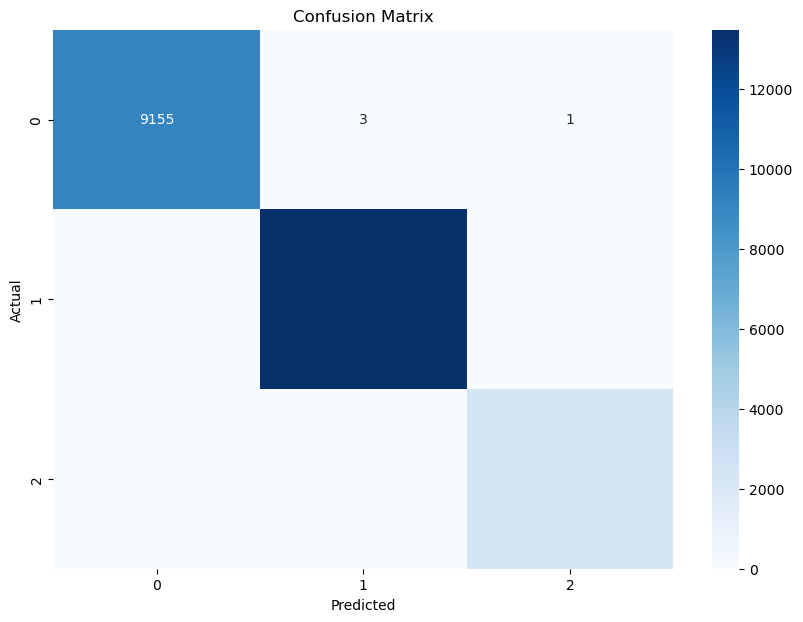

<Figure size 640x480 with 0 Axes>

In [5]:


# RF model with best parameters
best_params = {
    'bootstrap': False,
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 413,
    'class_weight': 'balanced',
    'random_state': 42
}

rf_model = RandomForestClassifier(**best_params)


# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_selected, y_train, cv=cv, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}, Standard Deviation: {np.std(cv_scores):.4f}')

# Membuat prediksi Cross-validation
y_pred_cv = cross_val_predict(rf_model, X_train_selected, y_train, cv=cv)


# Train the Random Forest model
rf_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_selected)

# Evaluate the model
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('cfmulti.png')

# Save the trained model to a .pkl file
with open('ids_test_multi_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [6]:
# with open('multi_test_scaler.pkl', 'wb') as scaler_file:
#     pickle.dump(scaler, scaler_file)
    
# with open('multi_test_le.pkl', 'wb') as f:
#     pickle.dump(label_encoders, f)


In [7]:

# # Save the trained model to a .pkl file
# with open('ids_multi_model.pkl', 'wb') as model_file:
#     pickle.dump(rf_model, model_file)

# print("Model saved as ids_model.pkl")

# with open('multi_scaler.pkl', 'wb') as scaler_file:
#     pickle.dump(scaler, scaler_file)
    
# with open('multi_le.pkl', 'wb') as f:
#     pickle.dump(label_encoders, f)



In [8]:

# # Step 1: Load the saved model
# with open('ids_test_multi_model.pkl', 'rb') as f:
#     model = pickle.load(f)
    
# with open('multi_test_scaler.pkl', 'rb') as f:
#     multi_scaler = pickle.load(f)
    
# with open('multi_test_le.pkl', 'rb') as f:
#     multi_le = pickle.load(f)
# # Step 2: Prepare your actual data (example, replace with your actual data preparation)
# # Assuming X_test_actual is your actual data in the format the model expects
# # Example: X_test_actual = pd.read_csv('your_new_data.csv')

# # Replace this with your actual data preparation
# X_test_actual = pd.read_csv('testnormalnoprepros.csv')

# # # Define the class mapping
# # class_mapping = {
# #     'normal': 'Normal',
# #     'neptune': 'DoS',
# #     'back': 'DoS',
# #     'teardrop': 'DoS',
# #     'pod': 'DoS',
# #     'smurf': 'DoS',
# #     'satan': 'Probe',
# #     'ipsweep': 'Probe',
# #     'portsweep': 'Probe',
# #     'nmap': 'Probe',
# #     'guess_passwd': 'R2L',
# #     'warezclient': 'R2L',
# #     'ftp_write': 'R2L',
# #     'imap': 'R2L',
# #     'phf': 'R2L',
# #     'spy': 'R2L',
# #     'buffer_overflow': 'U2R',
# #     'rootkit': 'U2R',
# #     'loadmodule': 'U2R',
# #     'perl': 'U2R'
# # }

# # # Apply the mapping to 'labels' column in X_test_actual
# # X_test_actual['labels'] = X_test_actual['labels'].map(class_mapping)

# # # Check the class distribution after mapping
# # class_counts = X_test_actual['labels'].value_counts()
# # print("Class Distribution:")
# # print(class_counts)

# # Convert categorical columns to string     type
# cols = ['protocol_type', 'service', 'flag']
# for col in cols:
#     X_test_actual[col] = X_test_actual[col].astype(str)

# # Encode categorical columns using label encoders trained on combined_data
# for col in cols:
#     le = multi_le[col]  # Reuse the label encoder from training
#     X_test_actual[col] = le.transform(X_test_actual[col])

# # Select top features and transform using scaler and PCA (assuming you've already defined these)
# top_features = ['service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count',
# 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
# 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
# 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
# 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

# X_test_selected = X_test_actual[top_features]
# X_test_selected = multi_scaler.transform(X_test_selected)
# # X_test_selected = pca.transform(X_test_selected)

# # Step 3: Make predictions
# predictions = model.predict(X_test_selected)

# # Display predictions
# print("Predictions:", predictions)

# # Extract true labels (assuming you have a 'labels' column in your dataset)
# y_true = X_test_actual['labels']


# # Calculate accuracy
# accuracy = accuracy_score(y_true, predictions)
# print(f"Accuracy: {accuracy:.4f}")




In [9]:
# # Calculate training accuracy
# train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_selected))
# print(f"Training Accuracy: {train_accuracy:.4f}")


In [10]:
# from sklearn.model_selection import learning_curve

# # Calculate learning curves
# train_sizes, train_scores, validation_scores = learning_curve(
#     rf_model, X_train_selected, y_train, cv=5, scoring='accuracy', 
#     train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
# )

# # Calculate the mean and standard deviation of the scores
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# validation_scores_mean = np.mean(validation_scores, axis=1)
# validation_scores_std = np.std(validation_scores, axis=1)

# # Plot learning curves
# plt.figure()
# plt.plot(train_sizes, train_scores_mean, label='Training score', color='r')
# plt.plot(train_sizes, validation_scores_mean, label='Validation score', color='g')
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')
# plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.2, color='g')
# plt.xlabel('Number of Training Examples')
# plt.ylabel('Score')
# plt.title('Learning Curves')
# plt.legend(loc='best')
# plt.show()


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve
# from sklearn.ensemble import RandomForestClassifier

# # Assuming X_train, y_train, X_test, y_test are already defined

# # Define the model
# model = RandomForestClassifier(random_state=42)

# # Generate learning curves
# train_sizes, train_scores, validation_scores = learning_curve(
#     model,
#     X_train,
#     y_train,
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPUs
#     train_sizes=np.linspace(0.1, 1.0, 10),  # Vary the training size
#     scoring='accuracy'
# )

# # Calculate the mean and standard deviation of the scores
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# validation_scores_mean = np.mean(validation_scores, axis=1)
# validation_scores_std = np.std(validation_scores, axis=1)

# # Plot learning curves
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_scores_mean, label='Training score', color='red')
# plt.plot(train_sizes, validation_scores_mean, label='Validation score', color='green')

# # Plot the standard deviation as shaded areas
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='red', alpha=0.2)
# plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='green', alpha=0.2)

# plt.xlabel('Number of Training Examples')
# plt.ylabel('Score')
# plt.title('Learning Curves')
# plt.legend()
# plt.grid()
# plt.show()


In [12]:
# from sklearn.decomposition import PCA
# import numpy as np

# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train[selected_features])
# X_test_pca = pca.transform(X_test_actual[selected_features])

# plt.figure(figsize=(12, 6))
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5, label='Train')
# plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.5, label='Test')
# plt.legend(loc='best')
# plt.title('PCA of Training and Test Data')
# plt.show()


In [13]:
# kdd_train = pd.read_csv('kdd_train.csv')
# kdd_test = pd.read_csv('kdd_test.csv')

# num_rows = kdd_train.shape[0]  # This gives the number of rows
# num_columns = kdd_train.shape[1]  # This gives the number of columns


# print(f"Number of rows: {num_rows}")
# print(f"Number of columns: {num_columns}")
# kdd_train

# import pandas as pd
# import dataframe_image as dfi

# # Sample DataFrame

# # Save the DataFrame as an image
# dfi.export(kdd_train, 'dataframe_image.png')  # Use df.head() for a small sample, or df for the full DataFrame
